In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import MSELoss

os.chdir('BayesHI')
import bayeshi

In [2]:
model = bayeshi.load_model('LSTMSequenceToSequence')

In [3]:
train_loader, val_loader, test_loader = bayeshi.load_data(y_values='absorption', seta_sim='comp', split=300000, tigress_sim=[300,310,320], verbose=True)

Loading TIGRESS simulation cube 300 (1/3) with x_values=emission and y_values=absorption
Loading TIGRESS simulation cube 310 (2/3) with x_values=emission and y_values=absorption
Loading TIGRESS simulation cube 320 (3/3) with x_values=emission and y_values=absorption
Splitting 300000 samples across 3 simulations: 100000 per simulation, with 0 extra samples distributed
Total number of spectra: 300000
Splitting data into 60% train, 20% validation, and 20% test sets.


Loading model from /home/120/em8117/lstmfulldata.pth
Model loaded successfully
Training Model
Initial learning rate: [0.001]
Epoch [1/8], Train Loss: 0.0020, Validation Loss: 0.0018, took 75.61s
Epoch [2/8], Train Loss: 0.0020, Validation Loss: 0.0018, took 75.21s
Epoch [3/8], Train Loss: 0.0019, Validation Loss: 0.0018, took 72.67s
Epoch [4/8], Train Loss: 0.0020, Validation Loss: 0.0019, took 75.00s
Epoch [5/8], Train Loss: 0.0019, Validation Loss: 0.0018, took 74.96s
Epoch [6/8], Train Loss: 0.0019, Validation Loss: 0.0018, took 74.91s
Epoch [7/8], Train Loss: 0.0019, Validation Loss: 0.0019, took 75.18s
Epoch [8/8], Train Loss: 0.0019, Validation Loss: 0.0018, took 75.01s


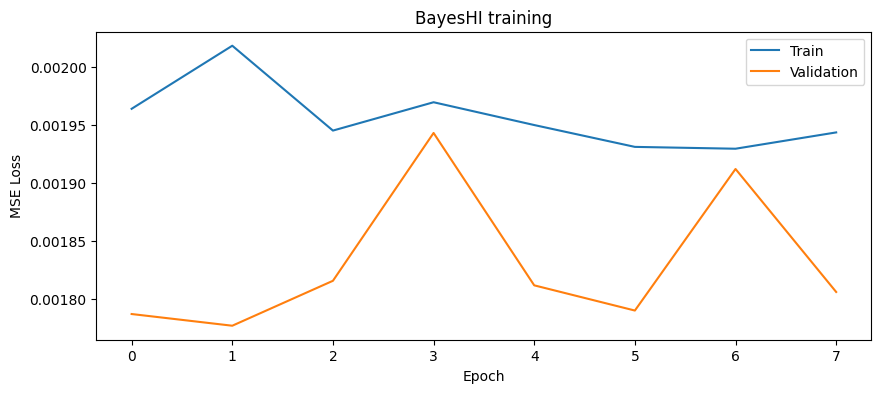

In [4]:
if os.path.exists('/home/120/em8117/lstmfulldata.pth'):
    model.load_weights('/home/120/em8117/lstmfulldata.pth')
else:
    train_errors, val_errors, *_ = model.fit(train_loader, val_loader, '/home/120/em8117/lstmfulldata.pth', nEpochs=50)
    plt.figure(figsize=(10,4))
    plt.plot(train_errors, label='Train')
    plt.plot(val_errors, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title(f'BayesHI training')
    plt.show()

In [5]:
# Predict on test set
predictions = model.predict(test_loader).cpu().numpy()

In [6]:
x_test = test_loader.dataset.tensors[0].cpu().numpy()
y_test = test_loader.dataset.tensors[1].cpu().numpy()

In [11]:
def hiep_plot(index):
    vch_em = np.linspace(-70,70, 256)
    
    ## Plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12), sharex=True)

    ## Emission
    ax1.plot(vch_em, x_test[index], 'k-', label=r'$T_{b}$ (kh)')
    
    # ax1.set_title('', fontsize = 35)
    
    ax1.set_ylabel('$T_{b} [K]$', fontsize = 35)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    # ax1.set_xlim(vlim1, vlim2)
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
    
    # Plot the things that the network is actually seeing and predicting
    ax2.plot(vch_em, y_test[index], 'k-', label='True')
    ax2.plot(vch_em, predictions[index], 'r-', label='Predicted')
    
    ax2.set_ylabel(r'$\tau$', fontsize = 35)
    ax2.set_xlabel('Vel [km/s]', fontsize = 35)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    # ax2.set_xlim(vlim1, vlim2)
    ax2.legend(loc='lower left', fontsize=12)
    
    ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
    
    ## Absorption
    ax3.plot(vch_em, np.exp(-y_test[index]), 'k-', label='True')
    ax3.plot(vch_em, np.exp(-predictions[index]), 'r-', label='Predicted')
    
    ax3.set_ylabel(r'$e^{-\tau}$', fontsize = 35)
    ax3.set_xlabel('Vel [km/s]', fontsize = 35)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.tick_params(axis='y', labelsize=20)
    # ax2.set_xlim(vlim1, vlim2)
    # ax3.legend(loc='lower left', fontsize=12)
    
    ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

    
    
    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=0.15,
                        hspace=0.005
                        )
    
    # plt.savefig(src + '.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)
    
    plt.show()
    plt.close(fig)

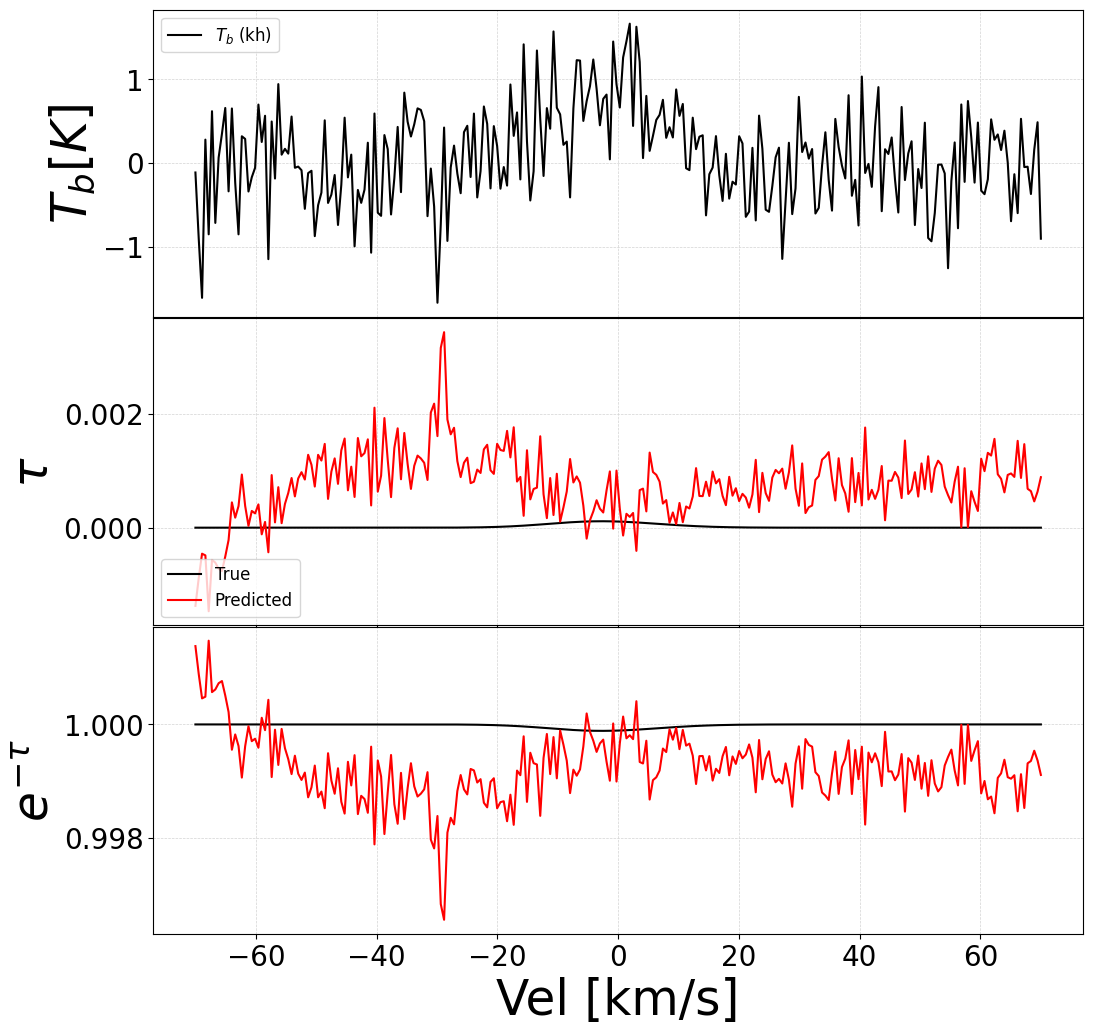

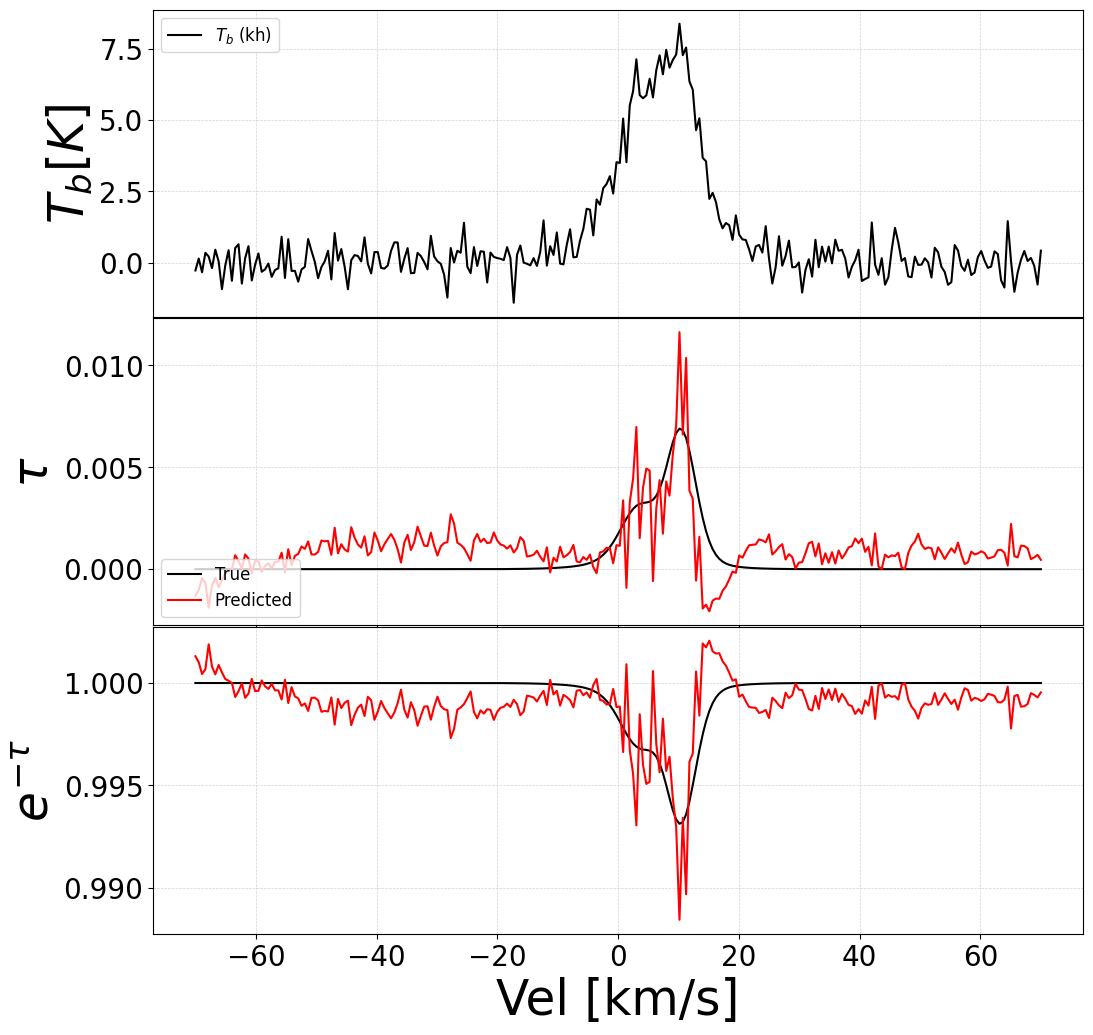

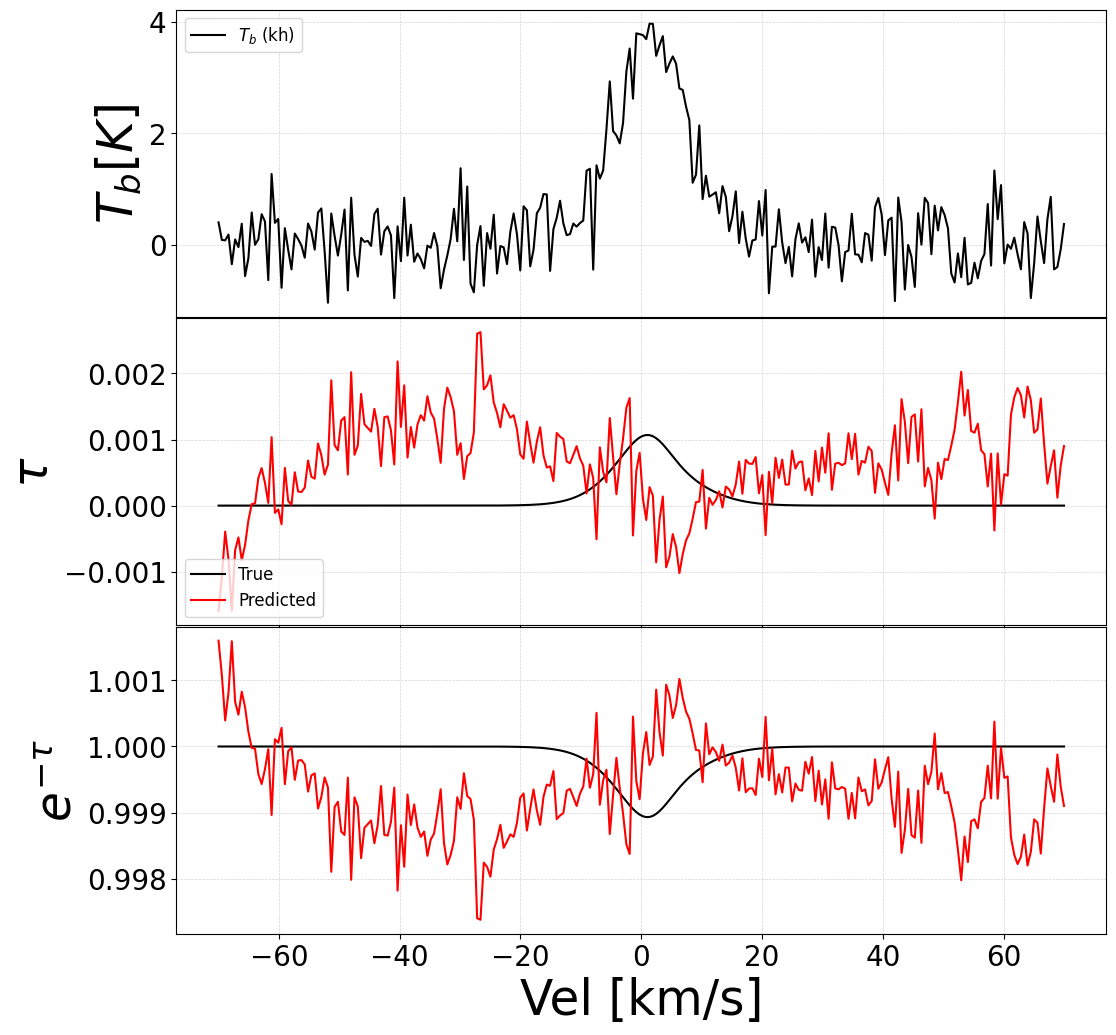

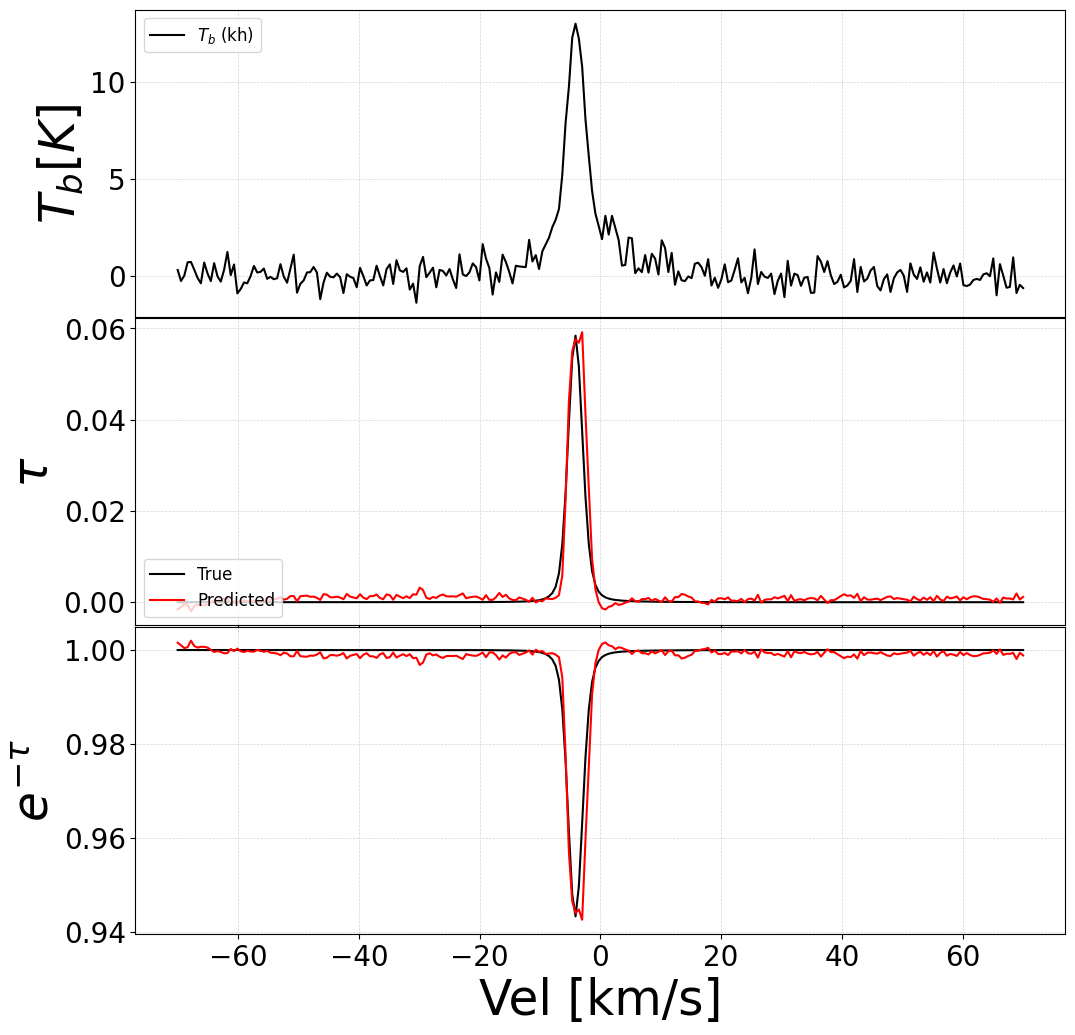

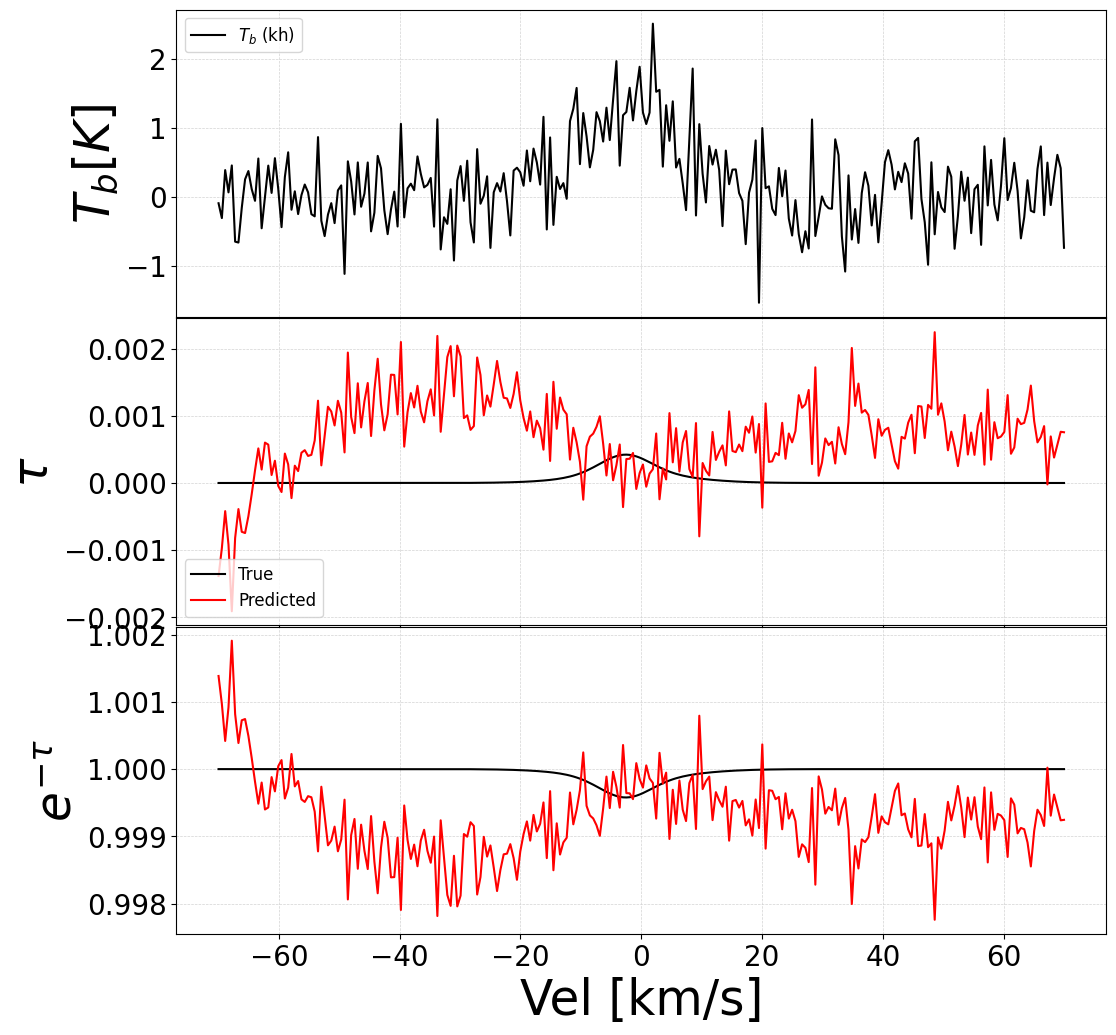

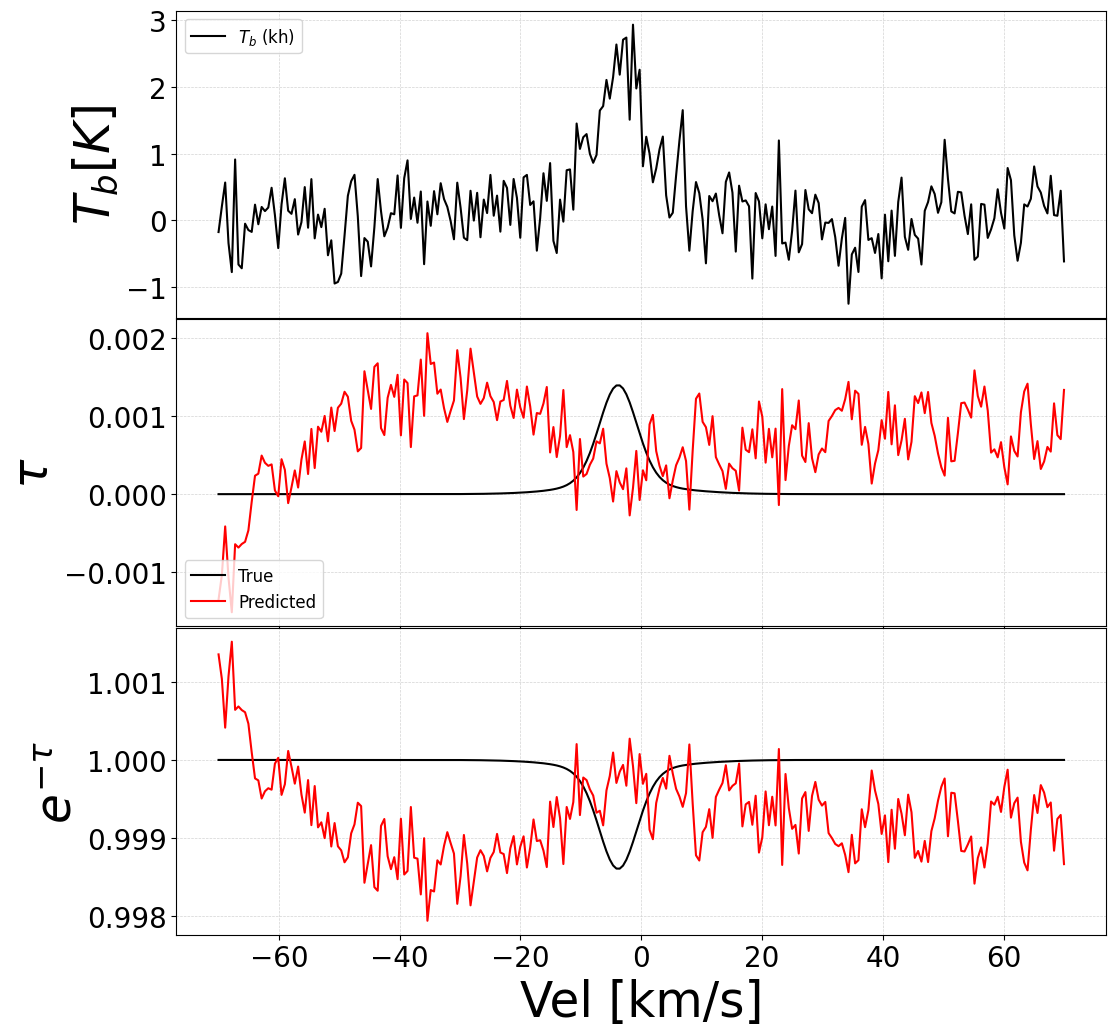

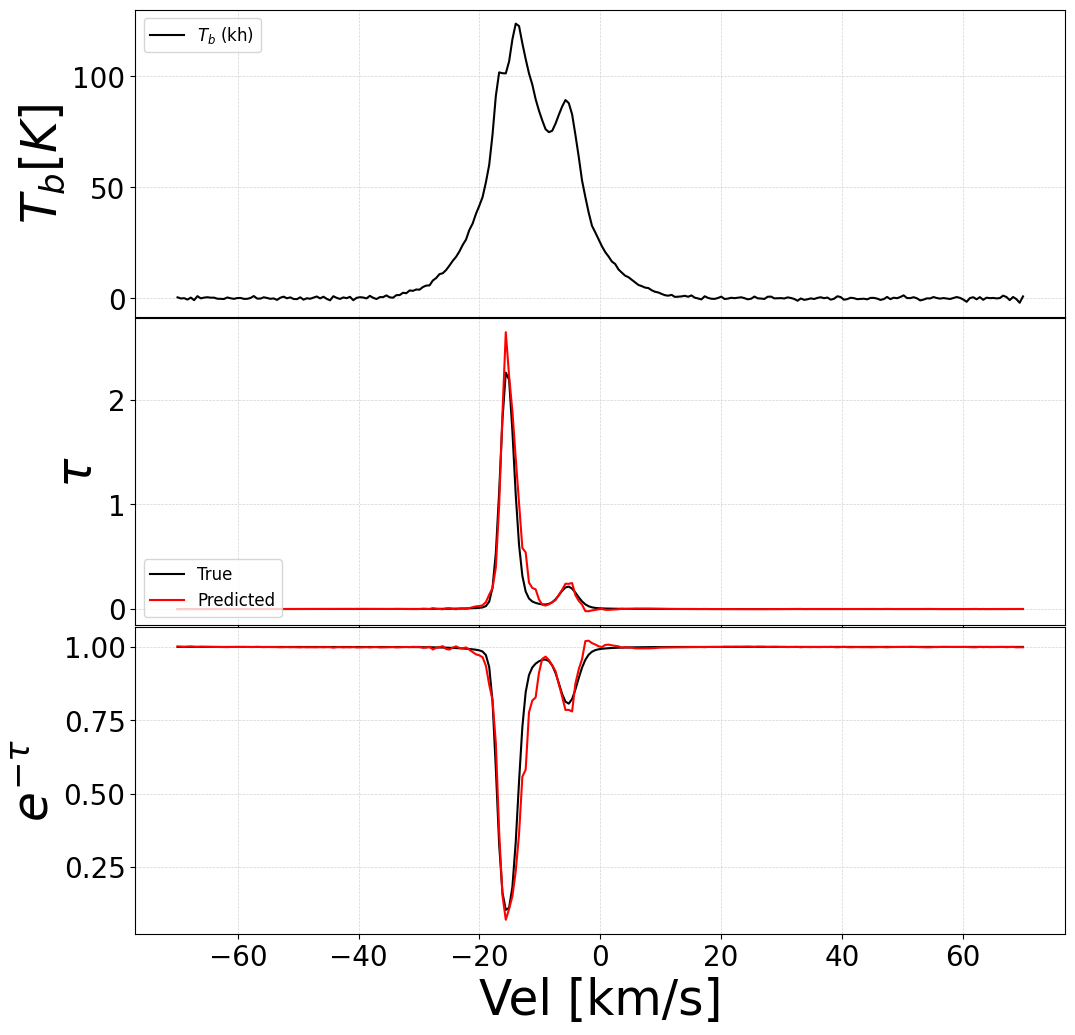

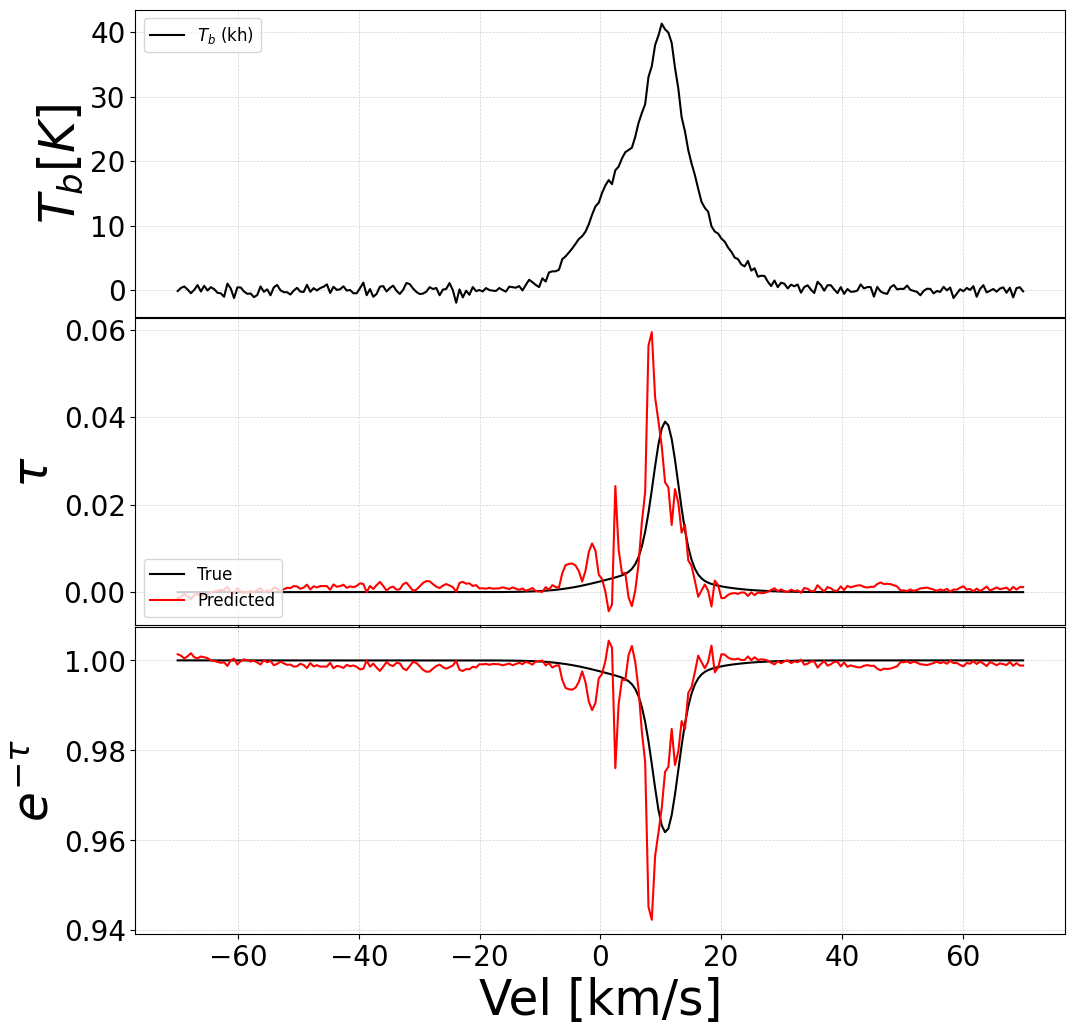

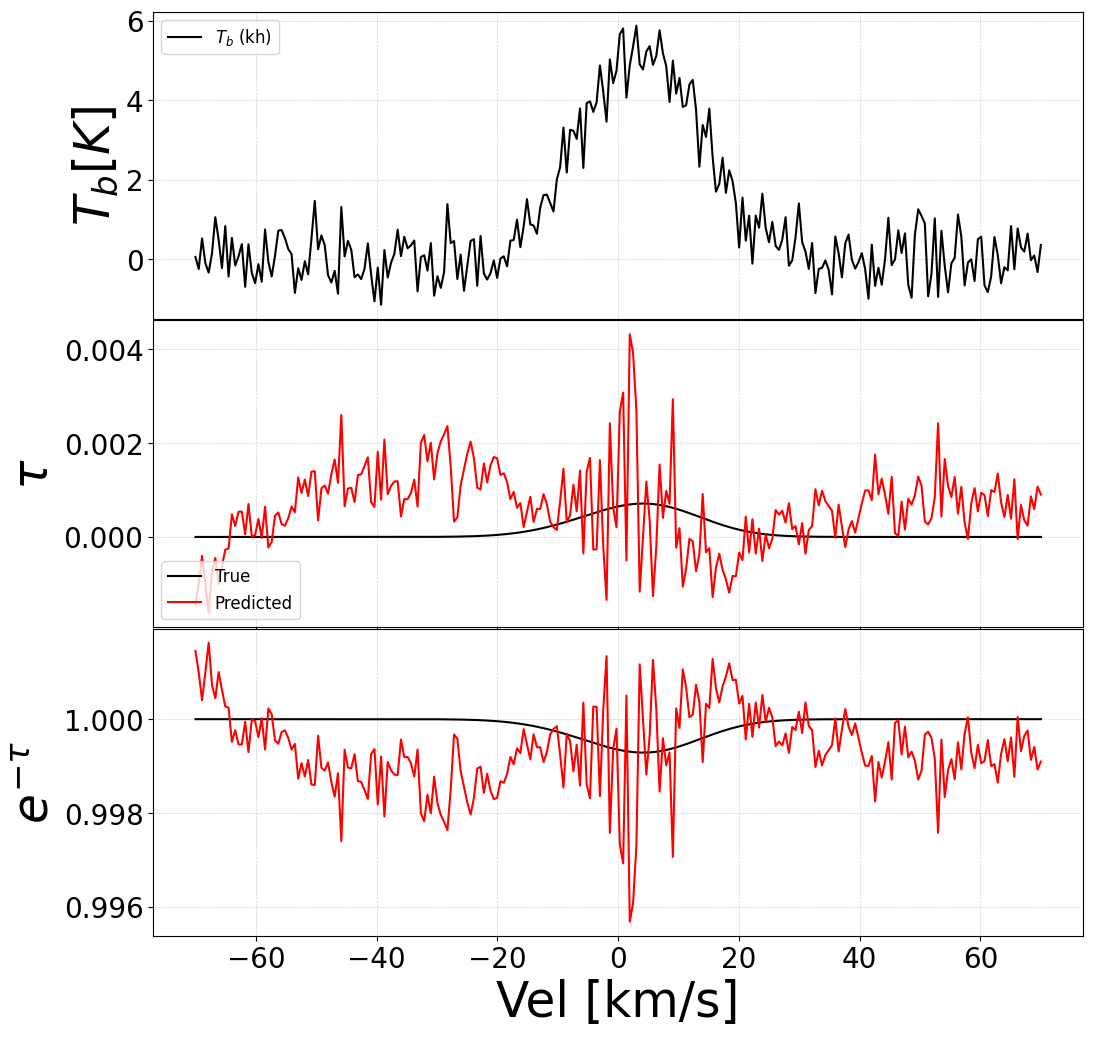

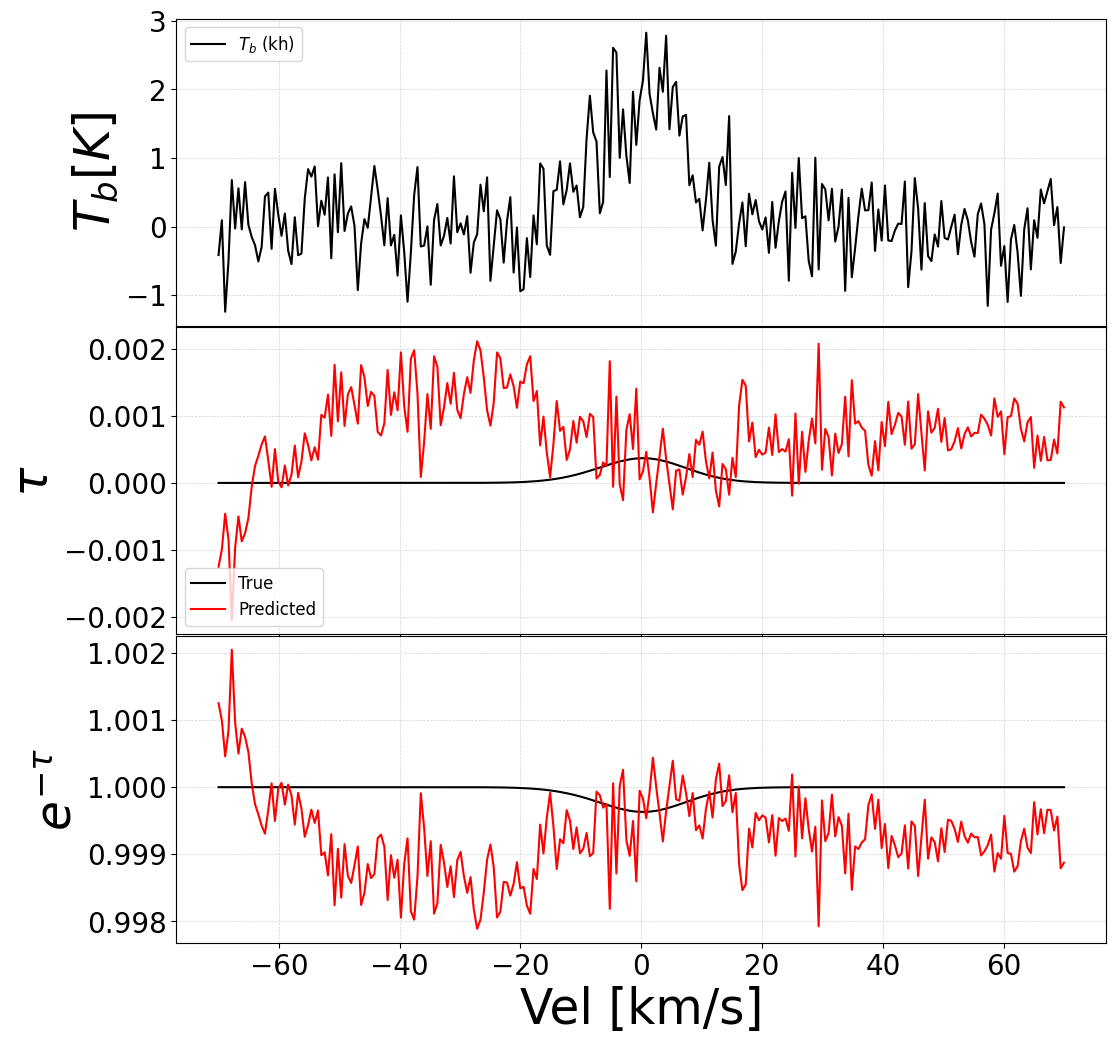

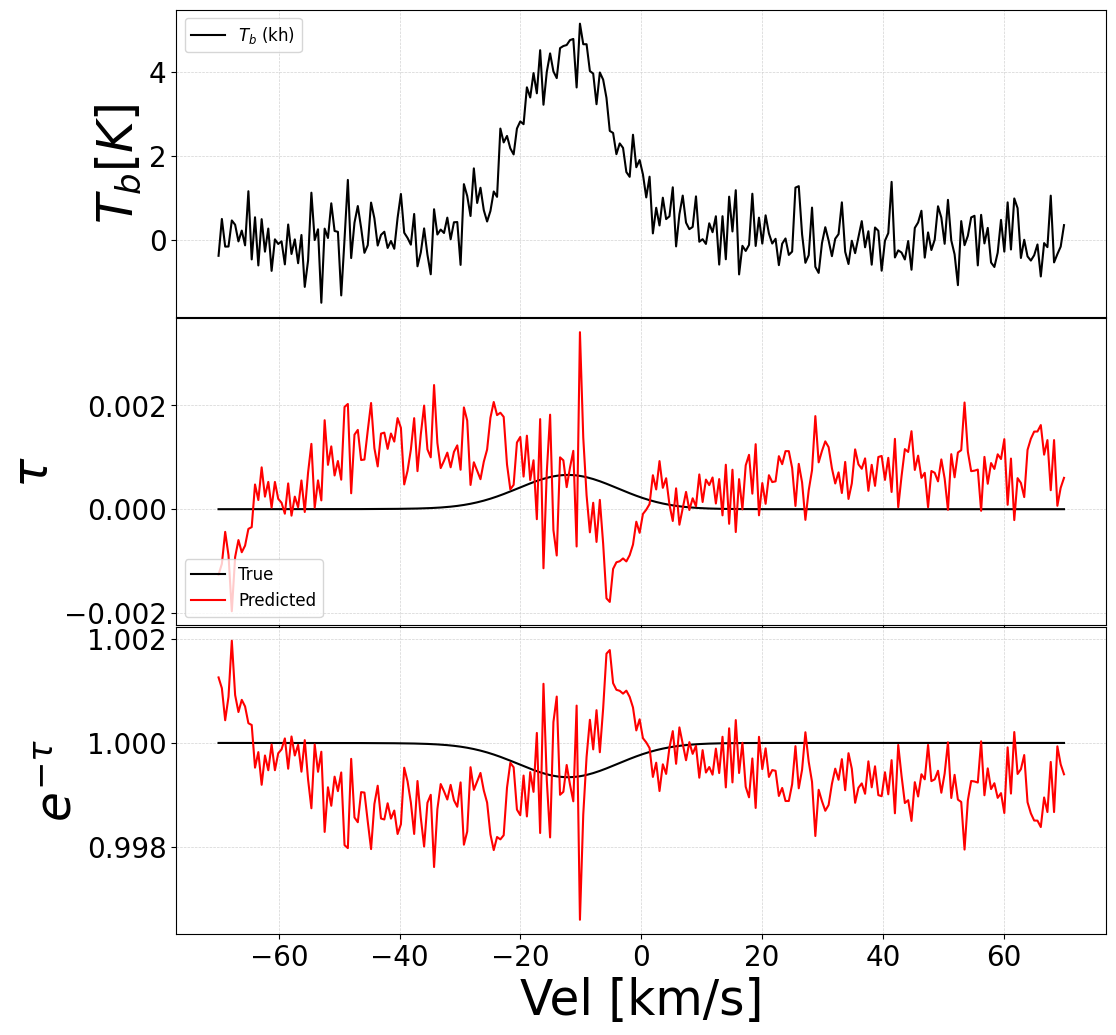

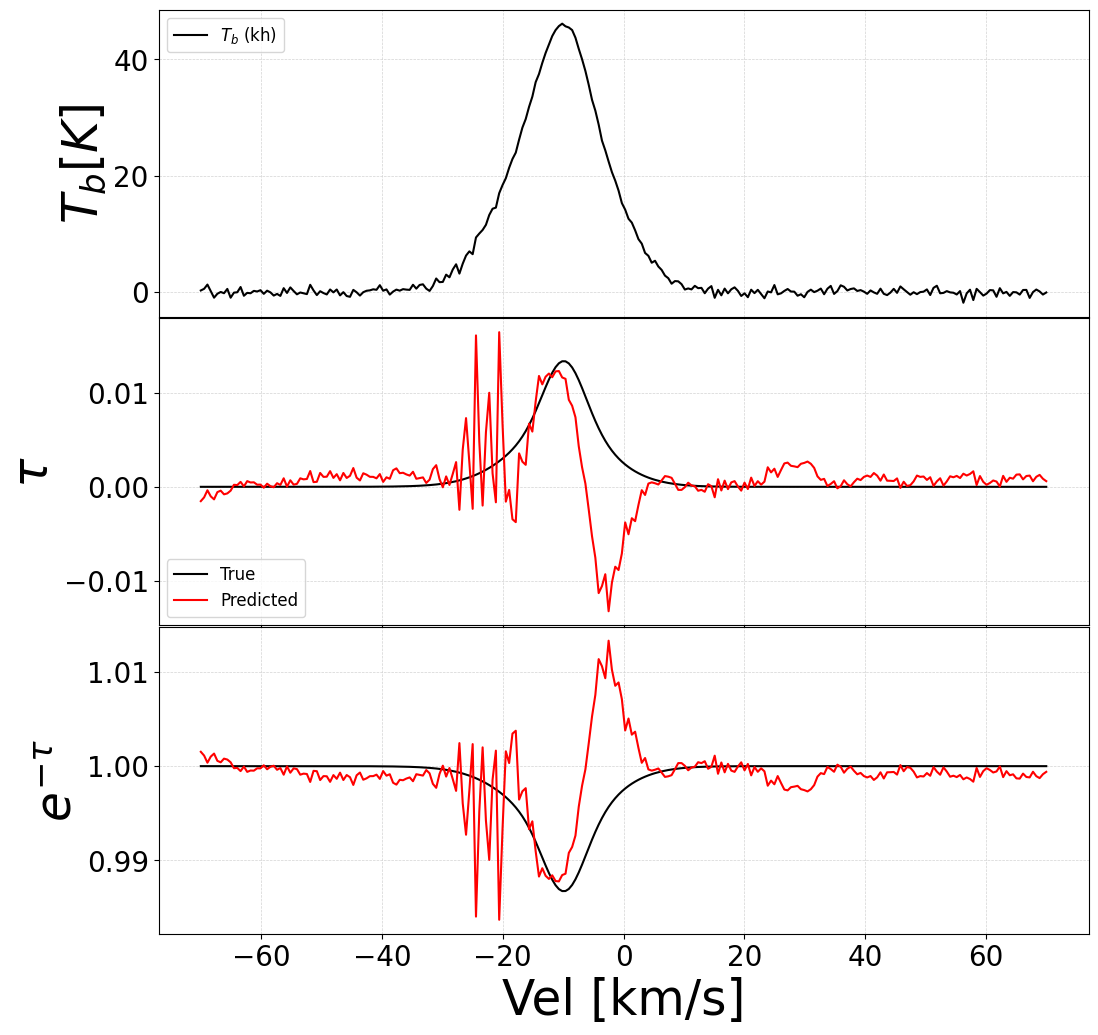

In [12]:
for i in [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,20000,30000]:
    hiep_plot(i)

In [19]:
y_test.shape

(60000, 256)

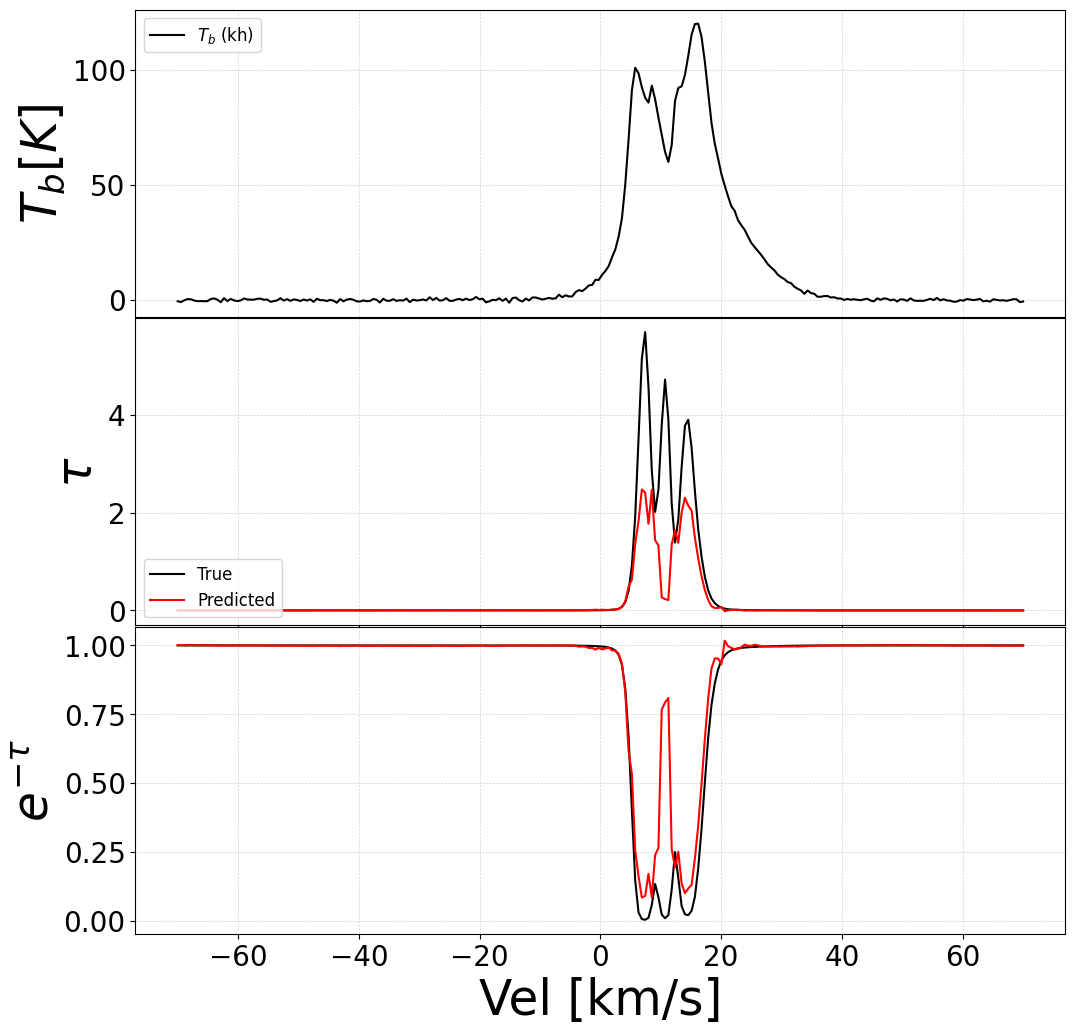

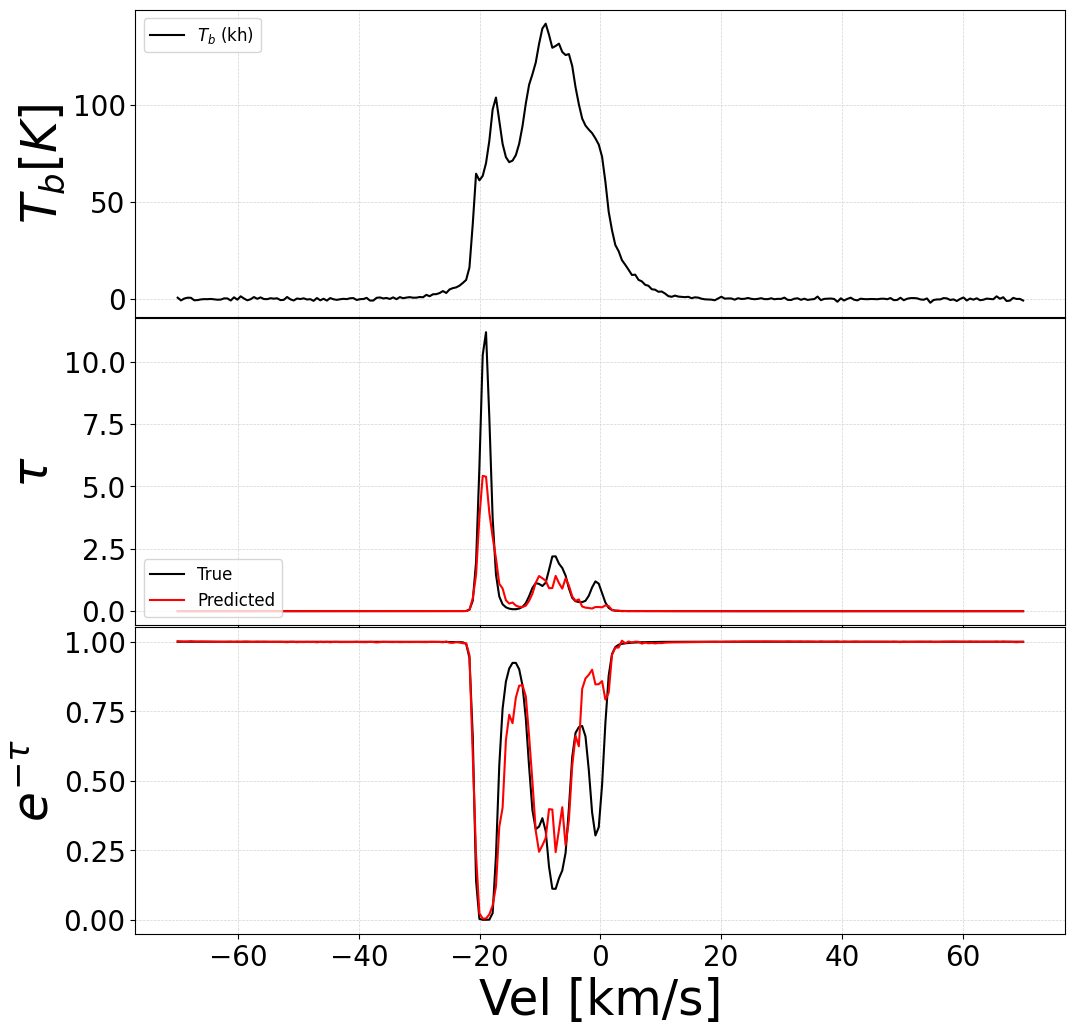

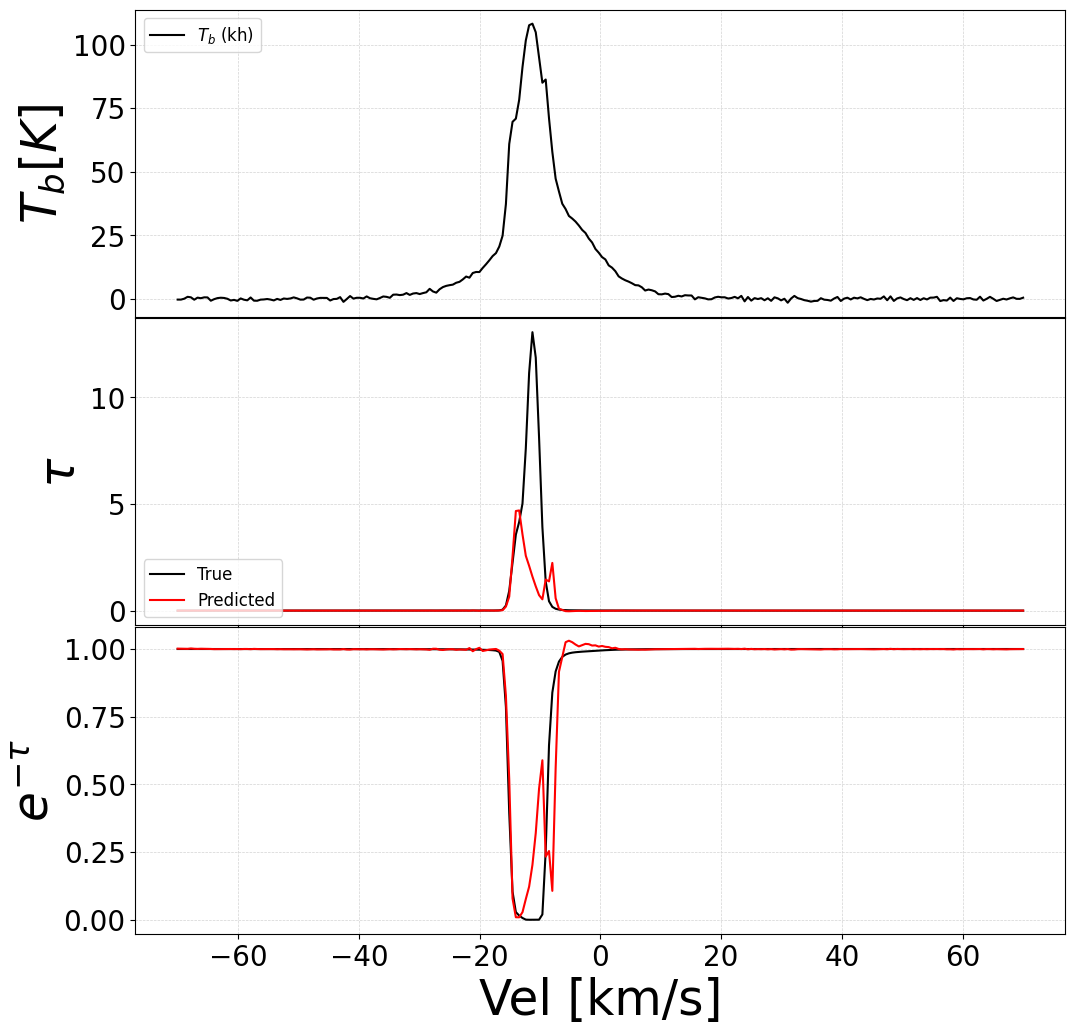

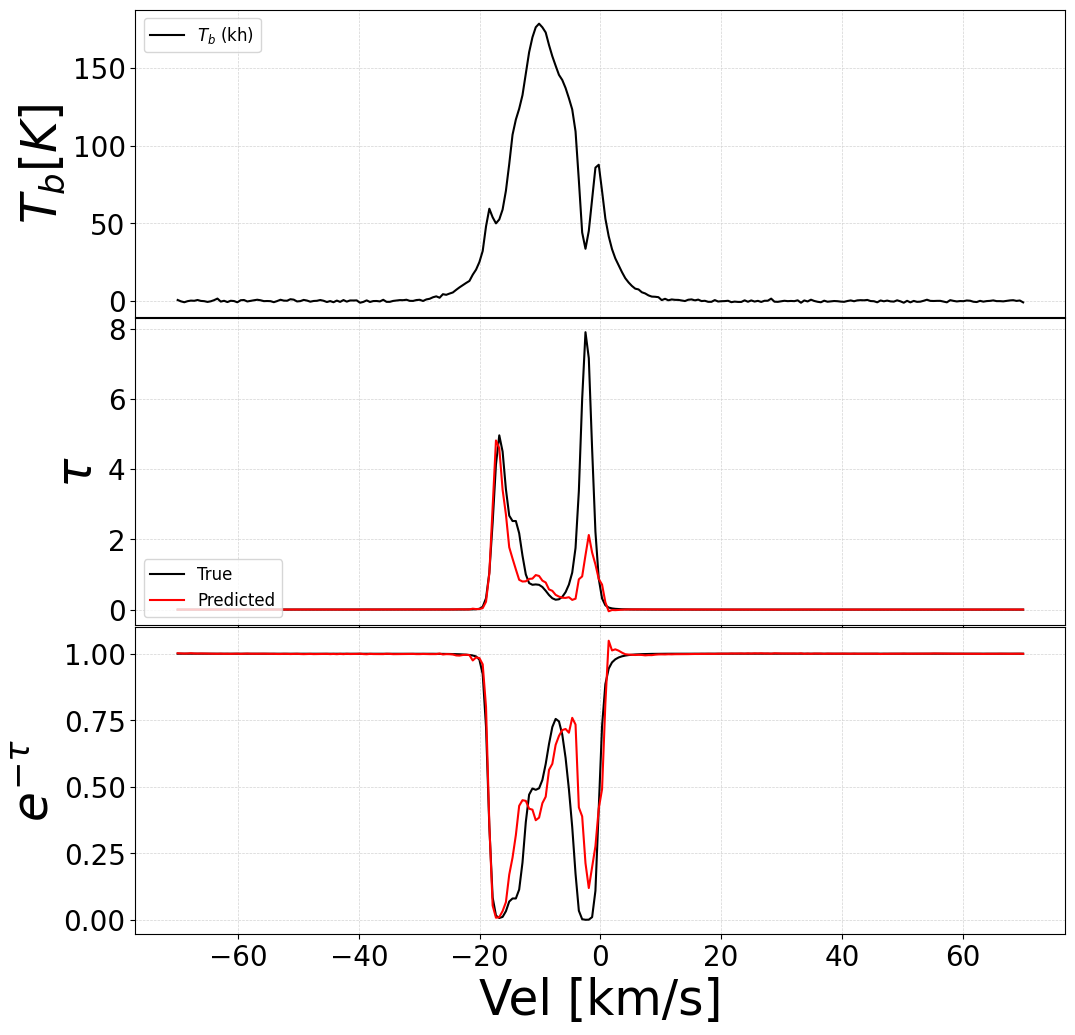

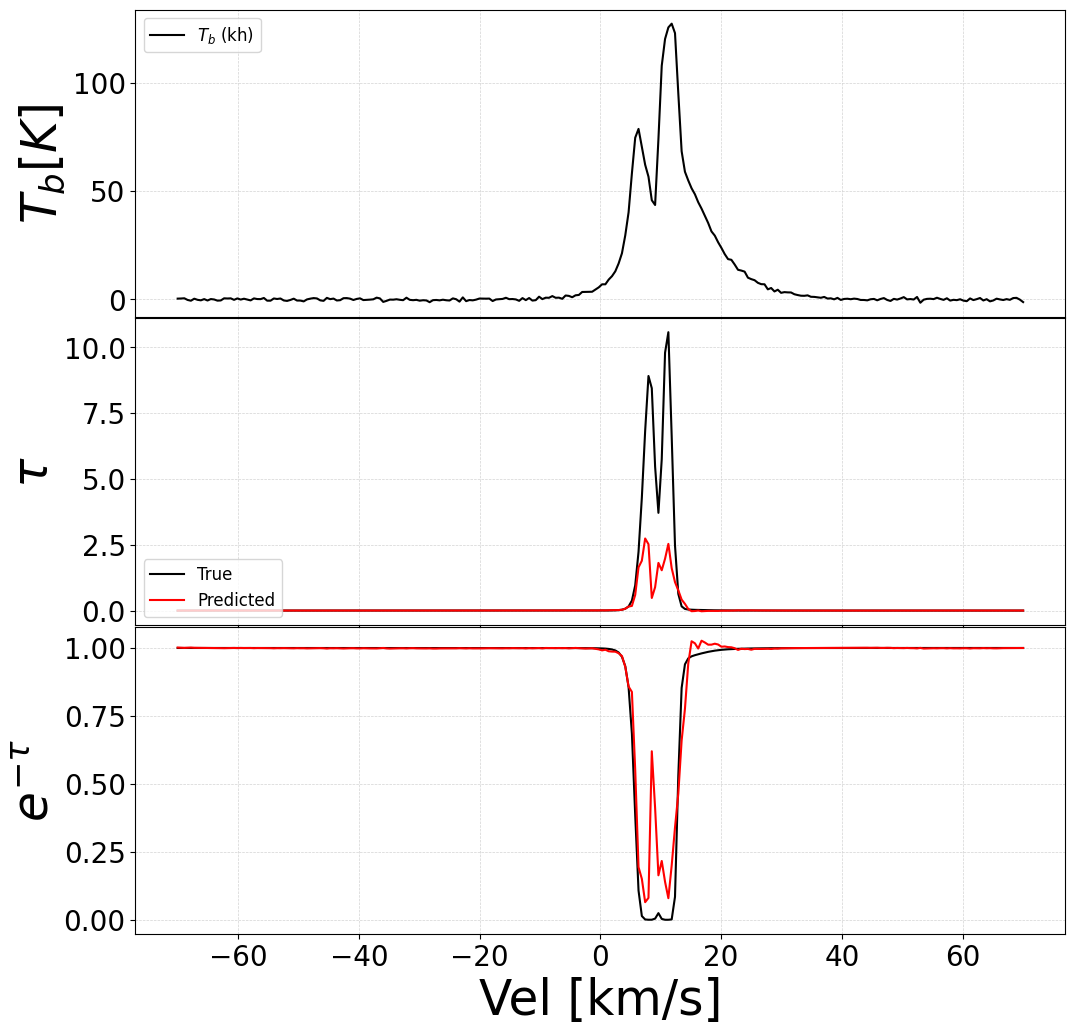

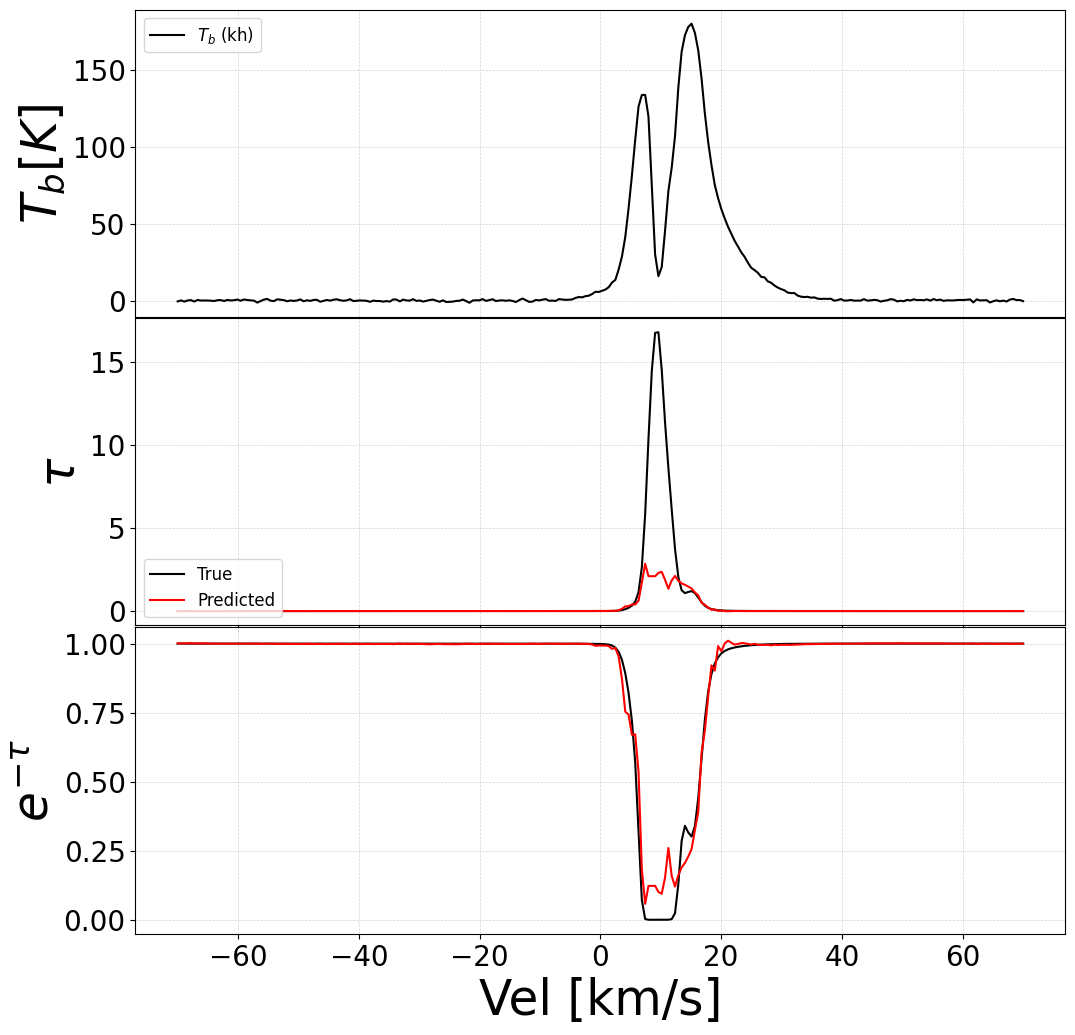

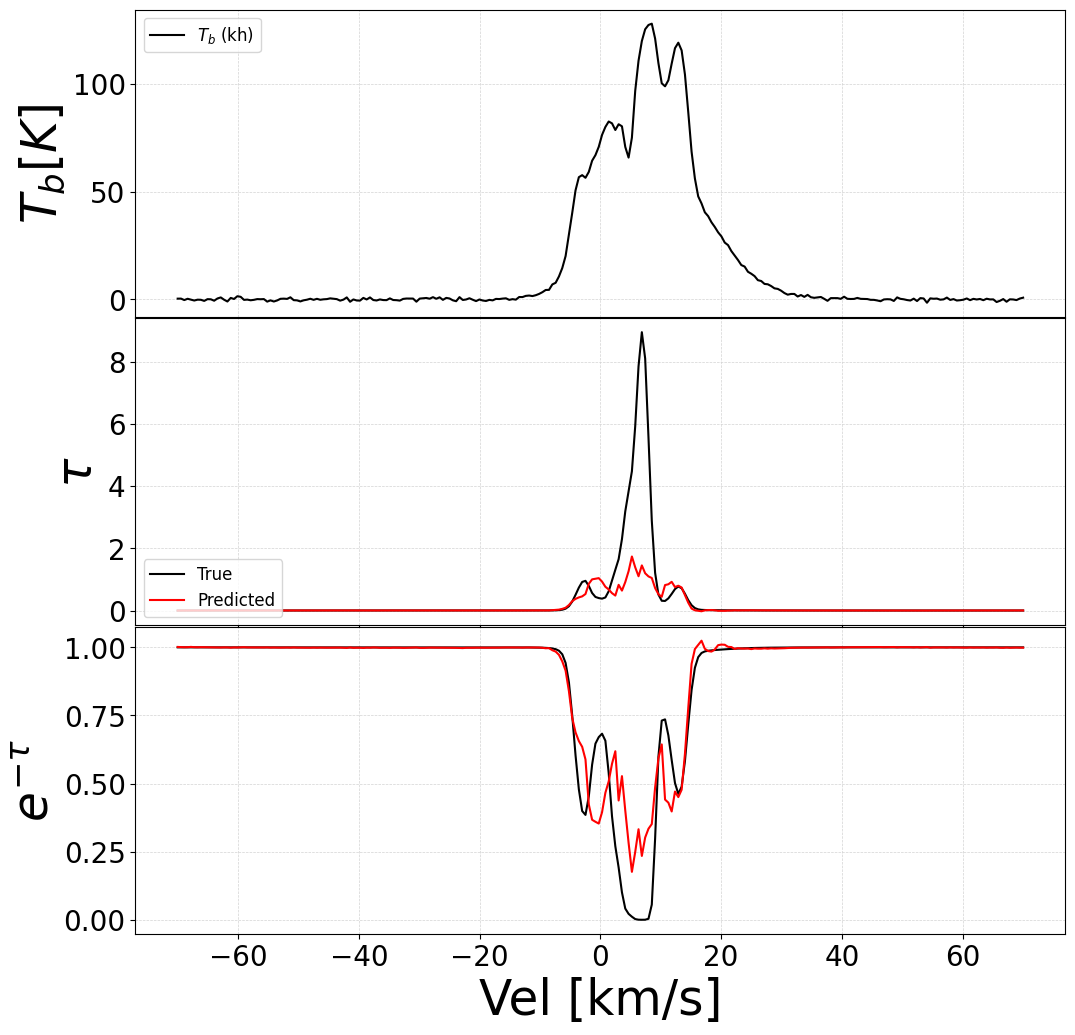

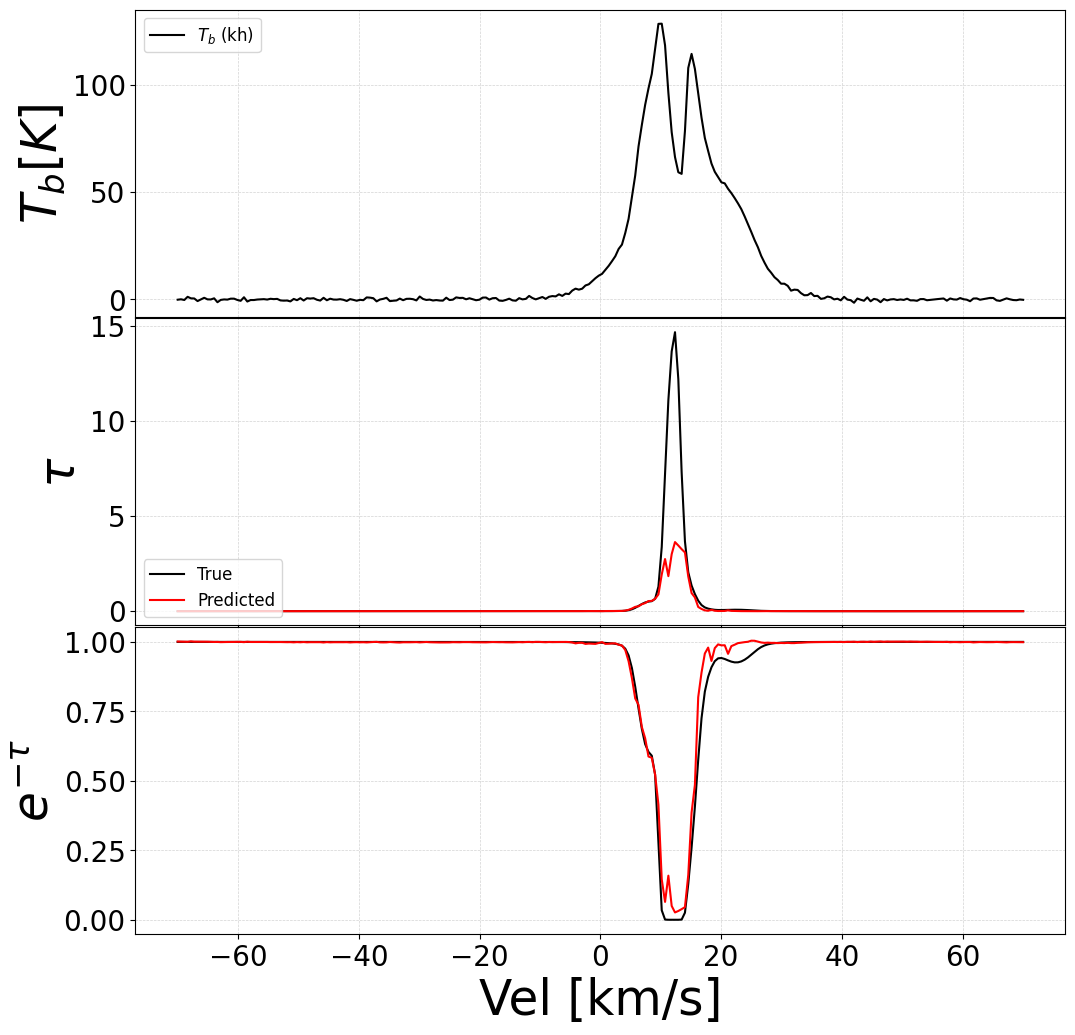

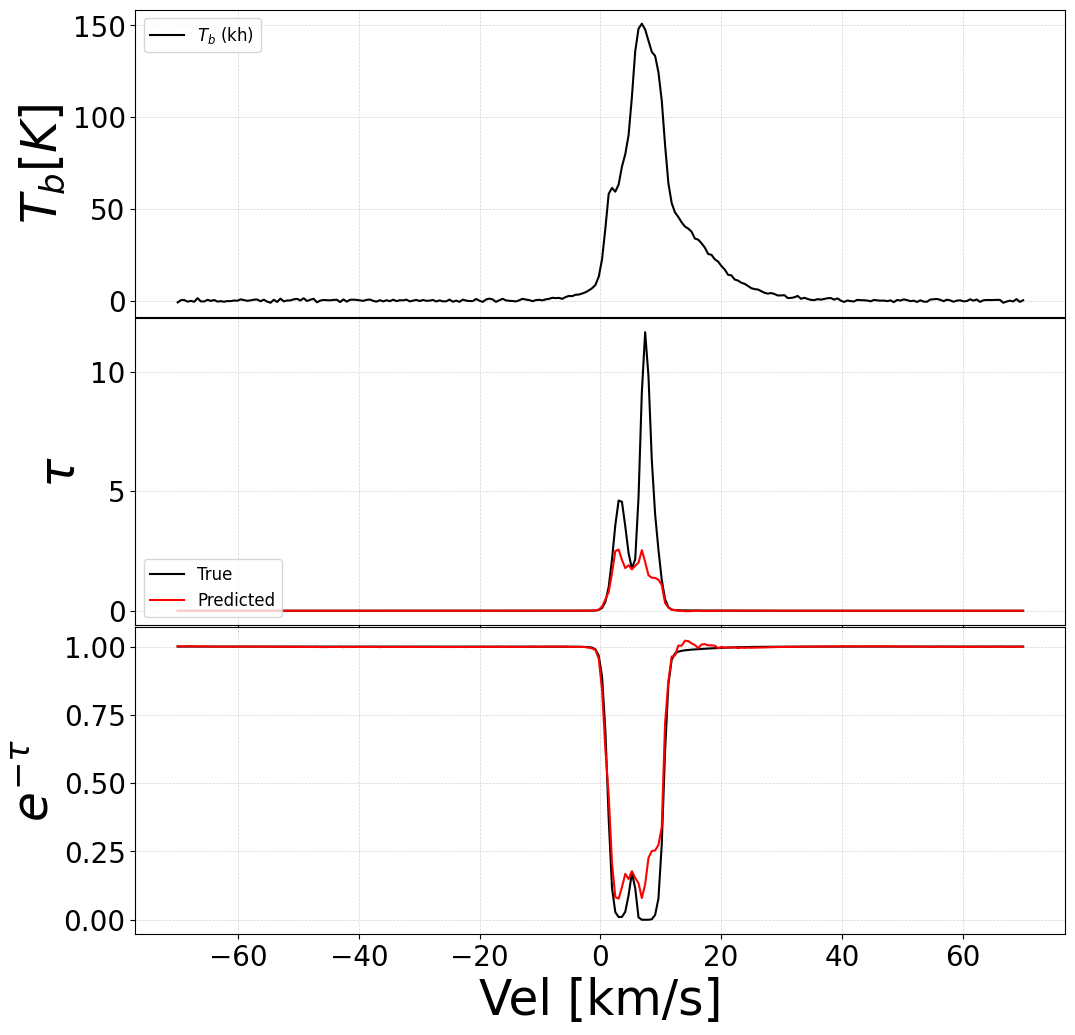

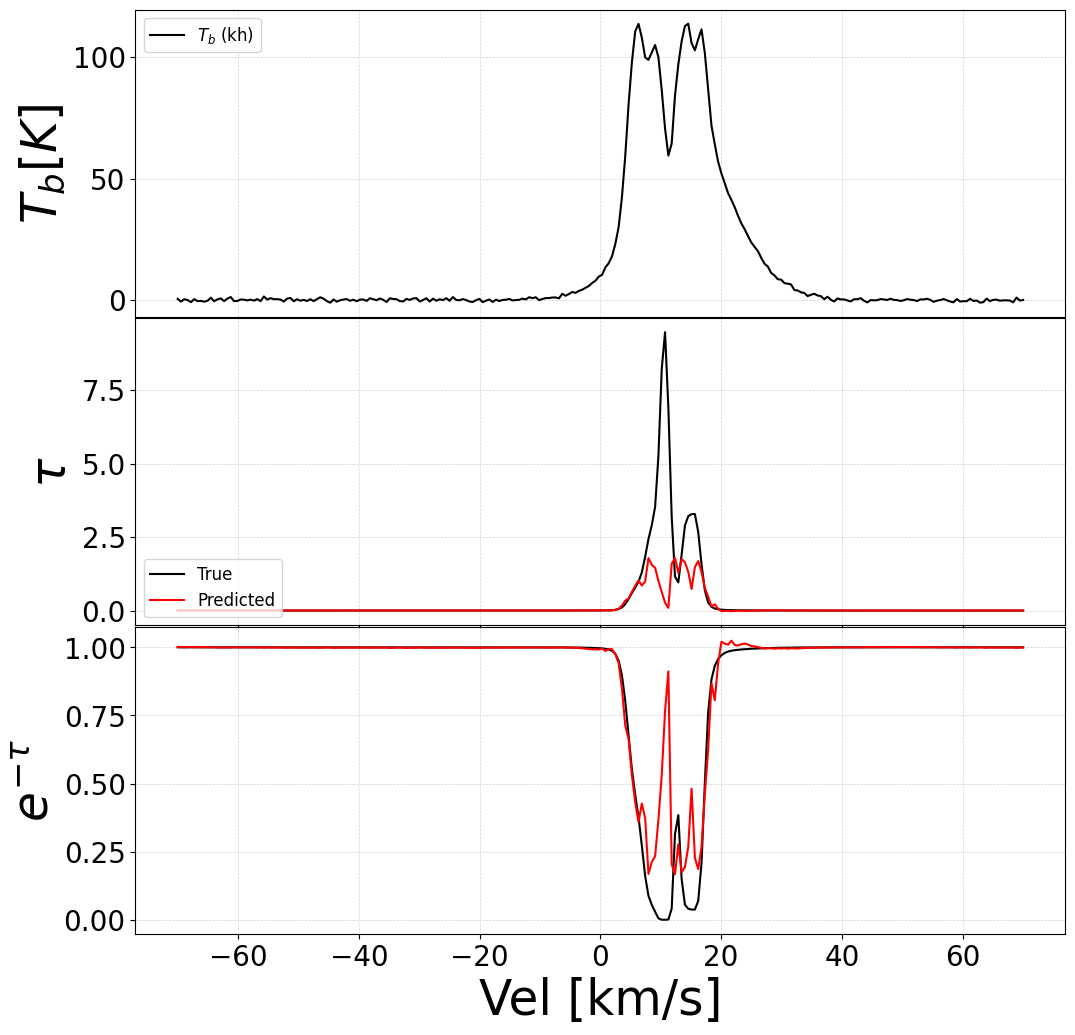

In [20]:
# Take the largest optical depth sightlines and plot

for i in np.argpartition(y_test.sum(axis=1), -10)[-10:]:
    hiep_plot(i)

In [13]:
def spectral_angle_mapper(targets, predictions, in_degrees=False, eps=1e-8):
    """
    Compute Spectral Angle Mapper (SAM) between two sets of spectra.

    Parameters:
    -----------
    targets : np.ndarray
        Array of true spectra with shape (N, C), where N = number of spectra and C = channels.
    predictions : np.ndarray
        Array of predicted spectra with shape (N, C), same shape as targets.
    in_degrees : bool
        If True, returns the angle in degrees. Otherwise, returns in radians.
    eps : float
        Small value to prevent division by zero.

    Returns:
    --------
    sam_angles : np.ndarray
        SAM values for each spectrum, shape (N,)
    """
    # Normalize vectors
    dot_products = np.sum(targets * predictions, axis=1)
    target_norms = np.linalg.norm(targets, axis=1)
    pred_norms = np.linalg.norm(predictions, axis=1)

    # Avoid division by zero
    denominator = np.clip(target_norms * pred_norms, a_min=eps, a_max=None)

    # Clamp cosine values to avoid invalid arccos due to numerical error
    cos_theta = np.clip(dot_products / denominator, -1.0, 1.0)
    angles = np.arccos(cos_theta)

    if in_degrees:
        angles = np.degrees(angles)

    return angles


In [14]:
angles = spectral_angle_mapper(y_test, predictions)

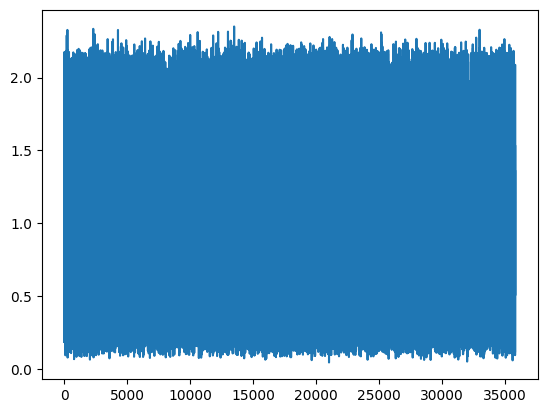

In [15]:
plt.plot(angles)
plt.show()

In [16]:
best_spectrum_idx = np.argmin(angles)
worst_spectrum_idx = np.argmax(angles)

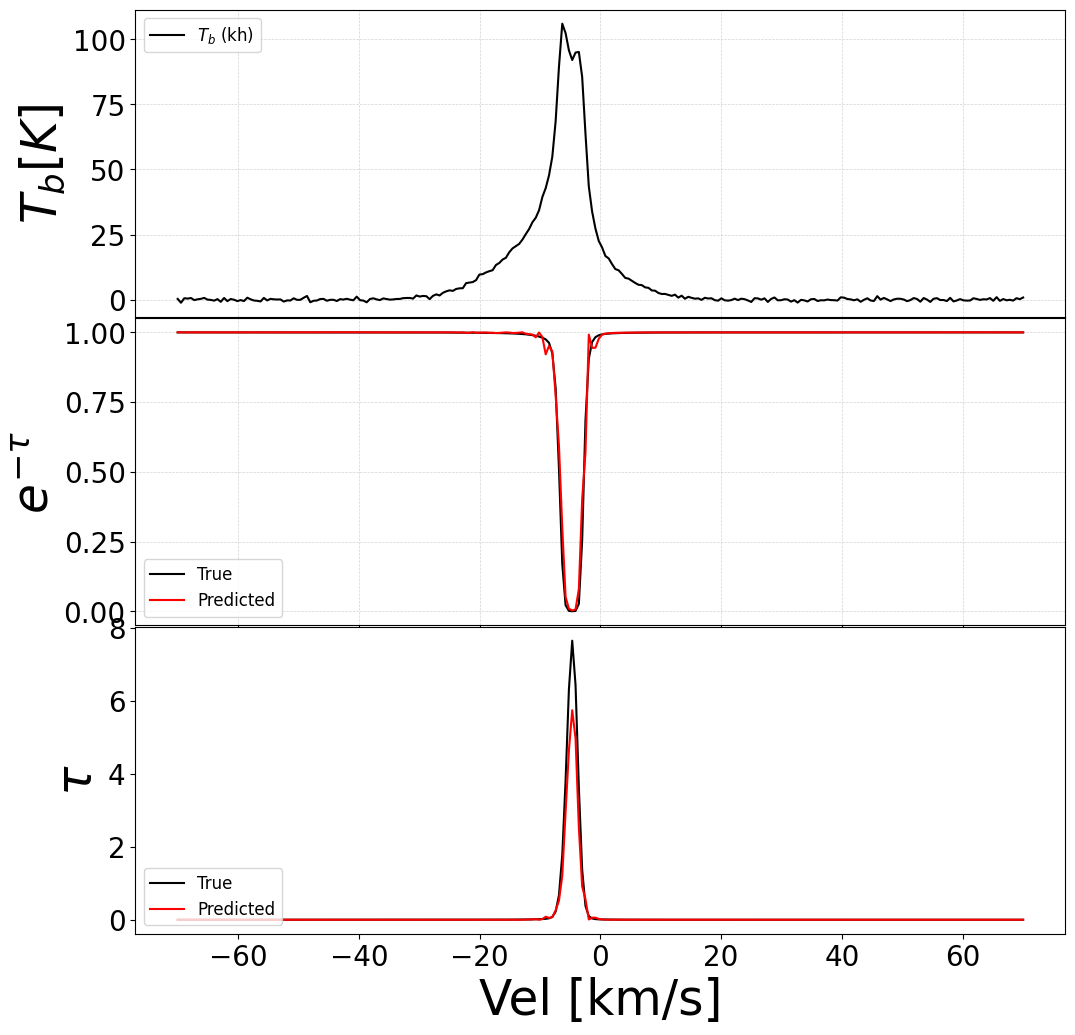

In [17]:
hiep_plot(best_spectrum_idx)

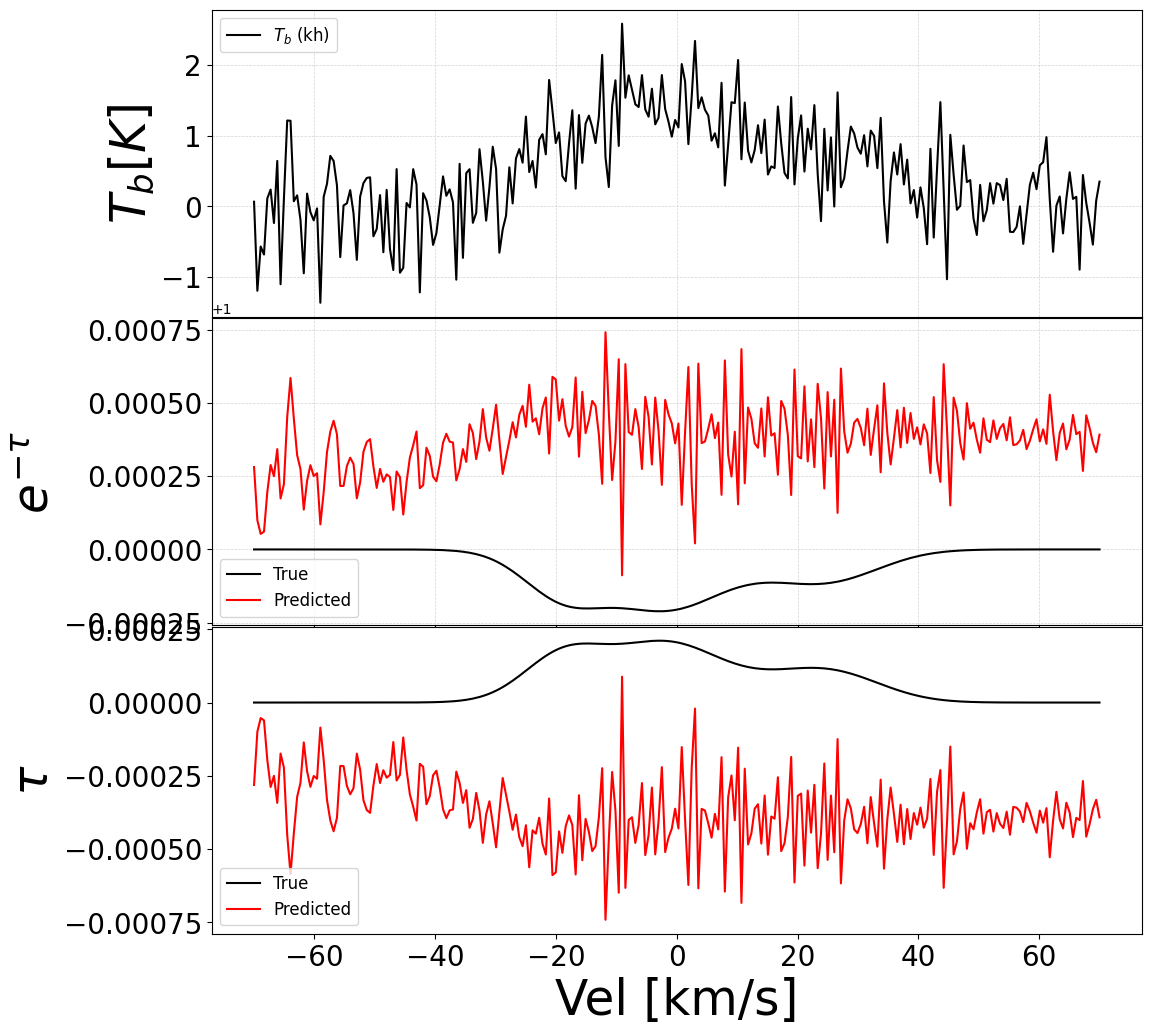

In [18]:
hiep_plot(worst_spectrum_idx)